# Deep Dream Experimentation

In [1]:
import numpy as np

import torch
from torch import nn
from torch import autograd as ag

from torchvision import models, transforms

import scipy.ndimage as nd
from skimage.transform import resize

import matplotlib.pyplot as plt
from matplotlib.image import imsave
from tqdm import tqdm_notebook as tqdm

Two helper functions that get move image between properly formatted tensors / np arrays.

In [2]:
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

def process_image(img):
    img_transform  = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize(means, stds)
                                        ])
    return img_transform(img).unsqueeze(0).float()

def unprocess_image(tens):
    means_ar = np.array(means).reshape(1, 1, 3)
    stds_ar  = np.array(stds ).reshape(1, 1, 3)
    
    arr = tens.numpy()[0, :, :, :]
    arr = arr.transpose(1, 2, 0)
    arr = stds_ar * arr + means_ar
    arr *= 255.0
    
    return np.uint8(np.clip(arr, 0, 255))

Importing the pretrained model

In [3]:
model = models.vgg19(pretrained = True).cuda()
modulelist = list(model.features.modules())

In [4]:
len(modulelist)

38

Basic deep dream function with no jitter or octaves. It is already possible to get reasonably good images from here.

In [5]:
def deep_dream_basic(image, layer = 28, n_iters = 6, lr = 0.3, show_bar=True):
    im_var = ag.Variable(process_image(image).cuda(), requires_grad = True)

            
    if show_bar:
        gen = tqdm(range(n_iters))
    else:
        gen = range(n_iters)
        
    for _ in gen:
        out = im_var

        for i in range(layer):
            out = modulelist[i+1](out)
        
        deep_act = out.norm()
        deep_act.backward(retain_graph = True)
        g = im_var.grad.data
        im_var.data += lr * g #/ g.abs().mean()
        
    return unprocess_image(im_var.data.cpu())

Import an image of clouds

C:\Users\willc\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  """Entry point for launching an IPython kernel.


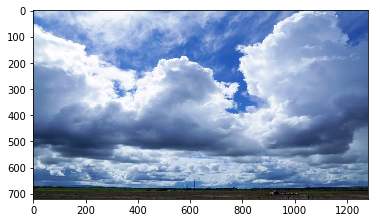

In [6]:
image = nd.imread('clouds.jpg')
plt.imshow(image)

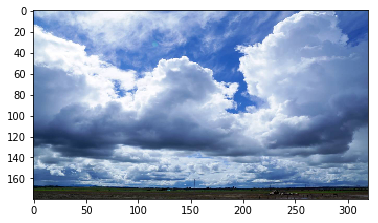

In [7]:
image_resize = nd.zoom(image, (1/4,1/4,1))
plt.imshow(image_resize)

Pretty cool results already. I actually think some of the nicest images come from this simple function

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

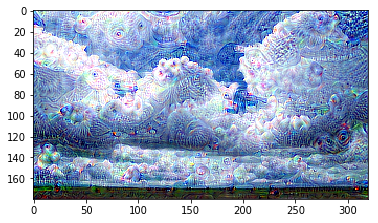

In [8]:
naive_dream = deep_dream_basic(image_resize, layer = 28, n_iters = 6, lr = 0.3)
plt.imshow(naive_dream)

In [9]:
imsave('clouds_dream_naive.jpg', naive_dream)

In [10]:
np.random.seed(42)

Helper function to privide the same functionality as np.roll for pytorch tensors

In [11]:
def roll(tensor, shift, axis):
    shift = int(shift)
    if shift == 0:
        return tensor

    if axis < 0:
        axis += tensor.dim()

    dim_size = tensor.size(axis)
    after_start = dim_size - shift
    if shift < 0:
        after_start = -shift
        shift = dim_size - abs(shift)

    before = tensor.narrow(axis, 0, dim_size - shift)
    after = tensor.narrow(axis, after_start, shift)
    return torch.cat([after, before], axis)

Extended deep dream function with random jitter

In [12]:
def deep_dream_with_jitter(image, layer = 20, n_iters = 5, lr = 0.3, jitter=32, show_bar=True):
    im_var = ag.Variable(process_image(image).cuda(), requires_grad = True)

            
    if show_bar:
        gen = tqdm(range(n_iters))
    else:
        gen = range(n_iters)
        
    for _ in gen:
        if jitter:
            x_offset, y_offset = np.random.randint(-jitter, jitter + 1, 2)
            im_var.data = roll(im_var.data, x_offset, 2)
            im_var.data = roll(im_var.data, y_offset, 3)
        
        out = im_var

        for i in range(layer):
            out = modulelist[i+1](out)
        
        deep_act = out.norm()
        deep_act.backward(retain_graph = True)
        g = im_var.grad.data
        im_var.data += lr * g #/ g.abs().mean()
        
        if jitter:
            im_var.data = roll(im_var.data, -x_offset, 2)
            im_var.data = roll(im_var.data, -y_offset, 3)
        
    return unprocess_image(im_var.data.cpu())

Jitter has the effect of reducing the change in the image per iteration

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

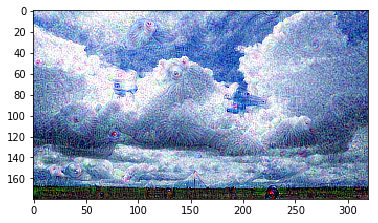

In [13]:
jitter_dream = deep_dream_with_jitter(image_resize, layer = 28, n_iters = 10, lr = 0.3, jitter = 32)
plt.imshow(jitter_dream)

Very simple octave function. I think I probably could get better results with a smarter implementation

In [14]:
def deep_dream_with_octaves(image, layer = 20, n_iters = 5, lr = 0.3, jitter=32, show_bar=True, n_octaves = 5, octave_scale = 1.4):
    blend_ratio = 0.6
    octave = image
    for i in tqdm(range(n_octaves)):
        octave = nd.zoom(octave, (1.0/octave_scale**i, 1.0/octave_scale**i, 1))
        octave = deep_dream_with_jitter(octave,layer=layer,n_iters=n_iters,lr=lr,jitter=jitter, show_bar=False)
        octave = resize(octave, image.shape)
    
    return octave

Pretty cool results. I'm a bit disapointed with the oversaturated colours though

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

C:\Users\willc\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


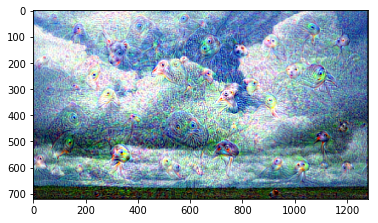

In [15]:
octaves_dream = deep_dream_with_octaves(image,layer=28,n_iters=20,lr=0.1,jitter=32,n_octaves=5,octave_scale=1.4)
plt.imshow(octaves_dream)

In [16]:
imsave('clouds_dream_oct.jpg', octaves_dream)

Experiment with another image

In [ ]:
image = plt.imread('flowers.jpg')
dream = deep_dream_with_octaves(image, layer = 28, n_iters = 10, lr = 0.3)
plt.imshow(dream)

## Telegram Bot

Right so a Jupyter notebook is all well and good but if I want to show off at the pub I'm going to want to access this on my phone so I made a telegram bot to interface with the function.

If you want to use this just put your telegram bot token in a file called 'chatbot_code.txt'

In [125]:
import telegram
import logging
from datetime import datetime
from telegram.error import NetworkError, Unauthorized
from time import sleep

with open('chatbot_code.txt', 'rb') as file:
    token = file.read().decode("utf-8")

bot = telegram.Bot(token)

In [126]:
def get_time():
    return str(datetime.now()).replace(' ', '-').replace(':', '-').replace('.', '-')

def get_closest(photos, desired_size):
    def diff(p): return p.width - desired_size[0], p.height - desired_size[1]
    def norm(t): return abs(t[0] + t[1] * 1j)
    return min(photos, key=lambda p:  norm(diff(p)))

In [127]:
def reply(bot, dream_fn):
    global update_id
    
    for update in bot.get_updates(offset = update_id, timeout=10000):
        update_id += 1
        print(update)
        
        if update.message.photo:
            from_usr = update.message.from_user.first_name
            
            im_path = 'chatbot_imgs/' + from_usr + get_time() + '.jpg'
            dream_im_path = 'chatbot_imgs/' + from_usr + 'dream' + get_time() + '.jpg'
            

            im_file = bot.get_file(get_closest(update.message.photo, (200, 300)).file_id)
            im_file.download(im_path)
            
            image = plt.imread(im_path)
            
            dream_img = dream_fn(image)
            imsave(dream_im_path, dream_img)
            
            update.message.reply_photo(photo = open(dream_im_path, 'rb'))
            
        elif update.message.text:
            from_usr = update.message.from_user.first_name
            update.message.reply_text('Send an image!')

In [ ]:
update_id = bot.get_updates()[0].update_id

while True:
    try:
        reply(bot, deep_dream_basic)
    except NetworkError:
        sleep(1)
    except Unauthorized:
        # The user has removed or blocked the bot.
        update_id += 1